# Analyzing NYC High School Data

The aim of this project is to explore relationships between SAT scores and demographic factors in New York City public schools. 
The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. We will use the following data sets in this analysis:

SAT scores by school - SAT scores for each high school in New York City

School attendance - Attendance information for each school in New York City

Class size - Information on class size for each school

AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

Graduation outcomes - The percentage of students who graduated, and other outcome information

Demographics - Demographic information for each school

School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test.

#### Initial results

After initial analysis of the data, it can be noticed that the SAT scores are determining by some of the demographic factors. Some of the initial assumptions:

- The safe schools present better results in this test, since a safe place is better for a learning environment.

- The schools with high percentege of white and asian students achieve better results than the ones who present high percentege of black and hipanic students.
- The gender does not present high influence in the SAT score results.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [16]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

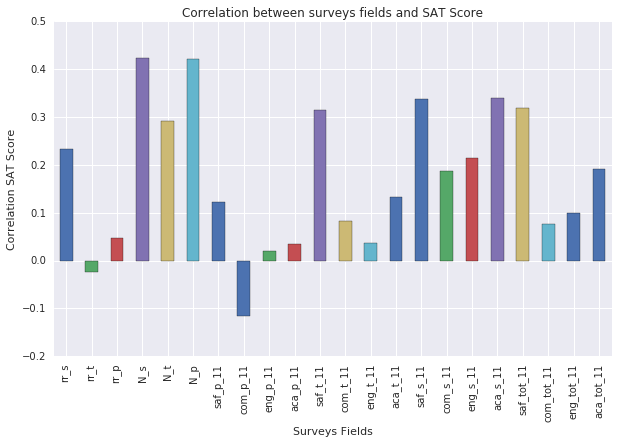

In [55]:
fig = plt.figure(figsize = (10,6))
plt.title('Correlation between surveys fields and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Surveys Fields')
combined.corr()["sat_score"][survey_fields].plot.bar()

Key:

The first three letters indicate the question asked:

aca: Academic expections

com: Communications

eng: Engagement

saf: Safety

r: Response rate

N: Total number of respondants

The next letters are the different categores of respondants.
p: parents

t: teachers

s: students

tot: Total of all the above categories

The trailing number, where present, indicates the position of the question on the survey.

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Exploring Safety

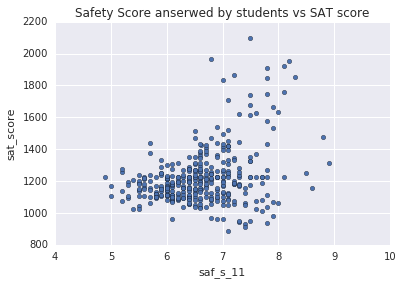

In [56]:
combined.plot.scatter(x= 'saf_s_11', y = 'sat_score')
plt.title('Safety Score anserwed by students vs SAT score')

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [22]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


In [29]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


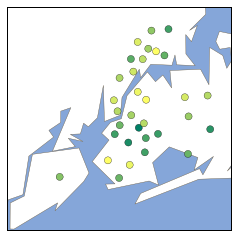

In [32]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()


It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Racial differences in SAT scores

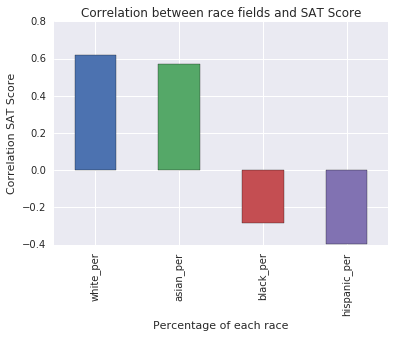

In [57]:
combined.corr()['sat_score'][['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar()
plt.title('Correlation between race fields and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Percentage of each race')

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

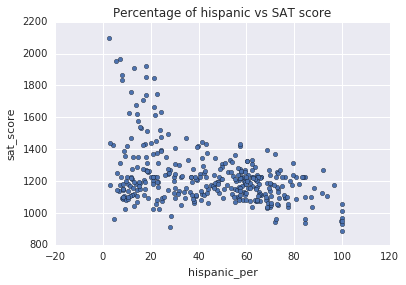

In [58]:
combined.plot.scatter(x='hispanic_per', y = 'sat_score')
plt.title('Percentage of hispanic vs SAT score')

In [38]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [40]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Gender differences in SAT scores

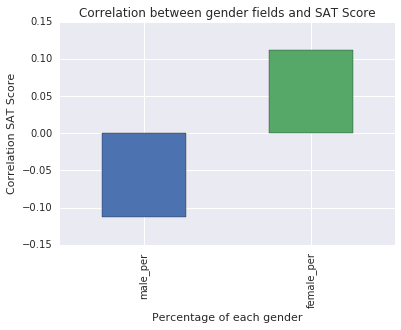

In [59]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()
plt.title('Correlation between gender fields and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Percentage of each gender')

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

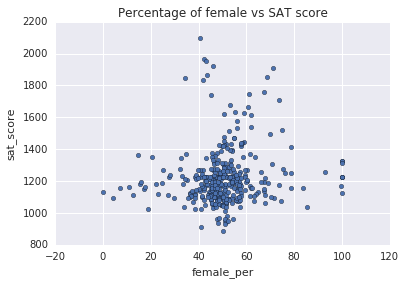

In [60]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')
plt.title('Percentage of female vs SAT score')

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [44]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

## AP Exam Scores vs SAT Scores

In [48]:
# calculating percentage of students in each school that took AP exam

combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] *100

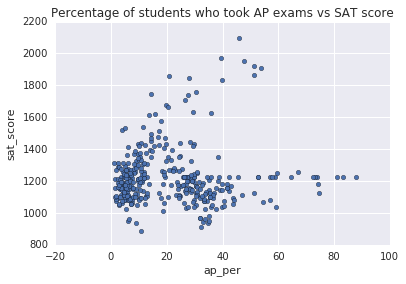

In [61]:
combined.plot.scatter(x = 'ap_per', y = 'sat_score')
plt.title('Percentage of students who took AP exams vs SAT score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

### Class size vs SAT score

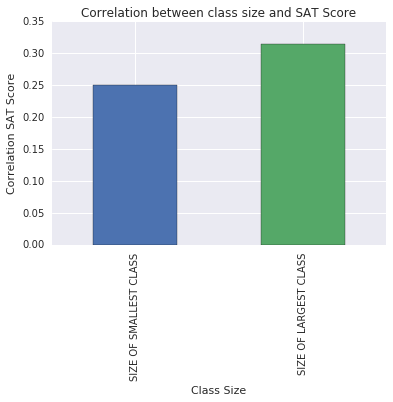

In [62]:
combined.corr()['sat_score'][['SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']].plot.bar()
plt.title('Correlation between class size and SAT Score')
plt.ylabel('Correlation SAT Score')
plt.xlabel('Class Size')

It looks like more largest class higher the SAT score. 

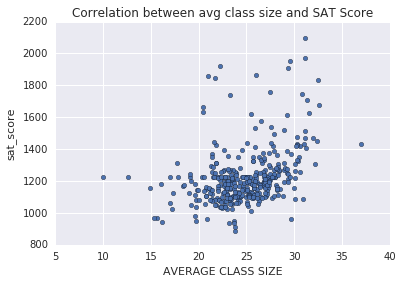

In [63]:
combined.plot.scatter(x = 'AVERAGE CLASS SIZE', y = 'sat_score')
plt.title('Correlation between avg class size and SAT Score')

There is some correlation betwwen class size and sat score. As we can see from the above scatter plot there are some schools where the average size of classes are between 30-34 and the sat score are realtively high. Most of the classes are between 20-30 with the sat_score around 100-1200. 

### Subsidized School Lunch vs SAT score

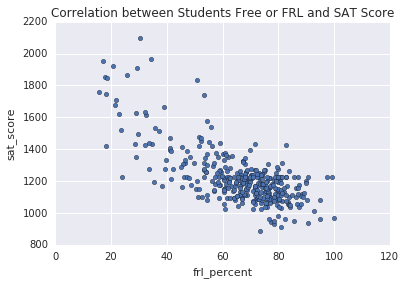

In [64]:
combined.plot.scatter(x = 'frl_percent', y = 'sat_score')
plt.title('Correlation between Students Free or FRL and SAT Score')

There is a strong negative correlation between sat score and students who receive free lunch or reduced-price lunch (FRL). 

In [67]:
combined[(combined['frl_percent'] > 90) & (combined['sat_score'] <1300)]['SCHOOL NAME']

31                 MANHATTAN ACADEMY FOR ARTS & LANGUAGE
83             HIGH SCHOOL FOR EXCELLENCE AND INNOVATION
87           HIGH SCHOOL FOR HEALTH CAREERS AND SCIENCES
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
94                   UNIVERSITY HEIGHTS SECONDARY SCHOOL
98                             NEW EXPLORERS HIGH SCHOOL
121                                 LEADERSHIP INSTITUTE
139                KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                        HIGH SCHOOL OF WORLD CULTURES
Name: SCHOOL NAME, dtype: object

## Conclusion
This analysis investigated factors that relate to average SAT performance at individual schools. The presence of these relationship should not be taken to imply a causal link. These relationships could exist because of coincidence, or because they stem from the same underlying cause, or because one is the cause of the other. This analysis can't distinguish among those possibilities.

### Analysis summary:

- There is no clear evidence of gender bias in the SAT.
- There is evidence that race and associated factors do relate to SAT scores. Nevertheless this relationship also seems to involve the relationship between race and low socioeconomic status.
- SAT scores of hispanic students are also likely influenced by a high percentage immigrant English language learners, many of whom didn't receive adequate schooling in their home countries. This intersects with the fact that the SAT is only given in English.


## Appendix

The source of the data used in this analysis is NYC's data portal. The specific source datasets follow:

- 2012 SAT ResultsEducation
- 2010 - 2011 School Attendance and Enrollment Statistics by District
- 2010-2011 Class Size - School-level detail
- 2010 AP (College Board) School Level Results
- 2005-2010 Graduation Outcomes - School Level
- 2006 - 2012 School Demographics and Accountability Snapshot
- 2011 NYC School Survey
- 2014 - 2015 DOE High School Directory